In [1]:
# univariate LSTM example
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#!pip install fastai==0.7.0
#!pip install sklearn==0.21.3
import datetime
import numpy as np
from numpy import array
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler



%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

TensorFlow 2.x selected.


In [2]:
SCREEN_X, SCREEN_Y = 12, 8
df = web.DataReader('COST', data_source = 'yahoo', start = '2010-01-01', end = '2019-12-17' )
#Date = pd.date_range('20150102',periods=1249)
df=df.reset_index()
print(df)
def CryptoData(symbol, frequency, start=0):
		df = web.DataReader('COST', data_source = 'yahoo', start = '2010-01-01', end = '2019-12-17' )
		return df

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)
  
  yhat = lstm.predict(x_seq)
  y = raw_seq[index]
  
  return x_seq, yhat, y

           Date        High         Low  ...       Close     Volume   Adj Close
0    2010-01-04   60.070000   59.130001  ...   59.410000  3280200.0   46.018879
1    2010-01-05   59.419998   58.840000  ...   59.230000  2775800.0   45.879436
2    2010-01-06   60.049999   59.000000  ...   60.000000  3722900.0   46.475872
3    2010-01-07   60.439999   59.259998  ...   59.709999  4527600.0   46.251236
4    2010-01-08   59.610001   59.099998  ...   59.279999  2348300.0   45.918163
...         ...         ...         ...  ...         ...        ...         ...
2502 2019-12-11  296.350006  293.049988  ...  295.299988  1749800.0  294.678711
2503 2019-12-12  297.760010  294.119995  ...  297.339996  2742700.0  296.714417
2504 2019-12-13  295.000000  289.100006  ...  291.869995  5195600.0  291.255920
2505 2019-12-16  294.459991  292.850006  ...  293.500000  2410000.0  292.882507
2506 2019-12-17  296.299988  292.750000  ...  295.549988  2474100.0  294.928162

[2507 rows x 7 columns]


In [3]:
startDate = int((datetime.datetime.strptime('1/1/2010', "%d/%m/%Y").timestamp()))
testSymbol = 'COST' #costco
# frequency = 86400s which is 1 day
df2 = CryptoData(testSymbol, 86400, startDate)
df2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,60.070000,59.130001,59.130001,59.410000,3280200.0,46.018879
2010-01-05,59.419998,58.840000,59.259998,59.230000,2775800.0,45.879436
2010-01-06,60.049999,59.000000,59.070000,60.000000,3722900.0,46.475872
2010-01-07,60.439999,59.259998,60.080002,59.709999,4527600.0,46.251236
2010-01-08,59.610001,59.099998,59.470001,59.279999,2348300.0,45.918163
...,...,...,...,...,...,...
2019-12-11,296.350006,293.049988,296.000000,295.299988,1749800.0,294.678711
2019-12-12,297.760010,294.119995,295.269989,297.339996,2742700.0,296.714417
2019-12-13,295.000000,289.100006,294.640015,291.869995,5195600.0,291.255920


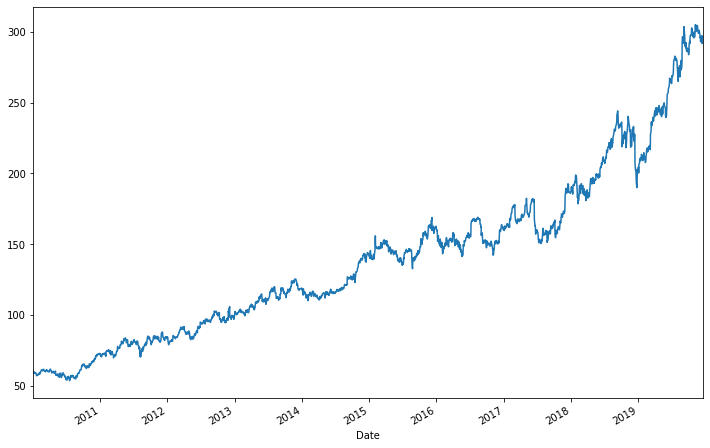

In [4]:
df2['Close'].plot(figsize = (SCREEN_X, SCREEN_Y))

**BASELINE**

In [5]:
# Get normalized training data
org_data = df.loc[:,'Close'].values
train_data= df2.loc[:,'Close'].values
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data_norm = train_data.reshape(-1,1)
print(org_data)

[ 59.40999985  59.22999954  60.         ... 291.86999512 293.5
 295.54998779]


In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0,2500,smoothing_window_size):
    scaler.fit(train_data_norm[di:di+smoothing_window_size,:])
    train_data_norm[di:di+smoothing_window_size,:] = scaler.transform(train_data_norm[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data_norm[di+smoothing_window_size:,:])
train_data_norm[di+smoothing_window_size:,:] = scaler.transform(train_data_norm[di+smoothing_window_size:,:])

In [0]:
# Reshape train data
train_data_norm = train_data_norm.reshape(-1)

In [8]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2507):
  EMA = gamma*train_data_norm[ti] + (1-gamma)*EMA
  train_data_norm[ti] = EMA

train_data_norm

array([0.01683599, 0.03146589, 0.04686792, ..., 0.79112367, 0.74181029,
       0.73490516])

Standard Average

In [9]:
window_size = 7
N = train_data_norm.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data_norm[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data_norm[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging:', np.mean(mse_errors))

MSE error for standard averaging: 0.0010780940141495608


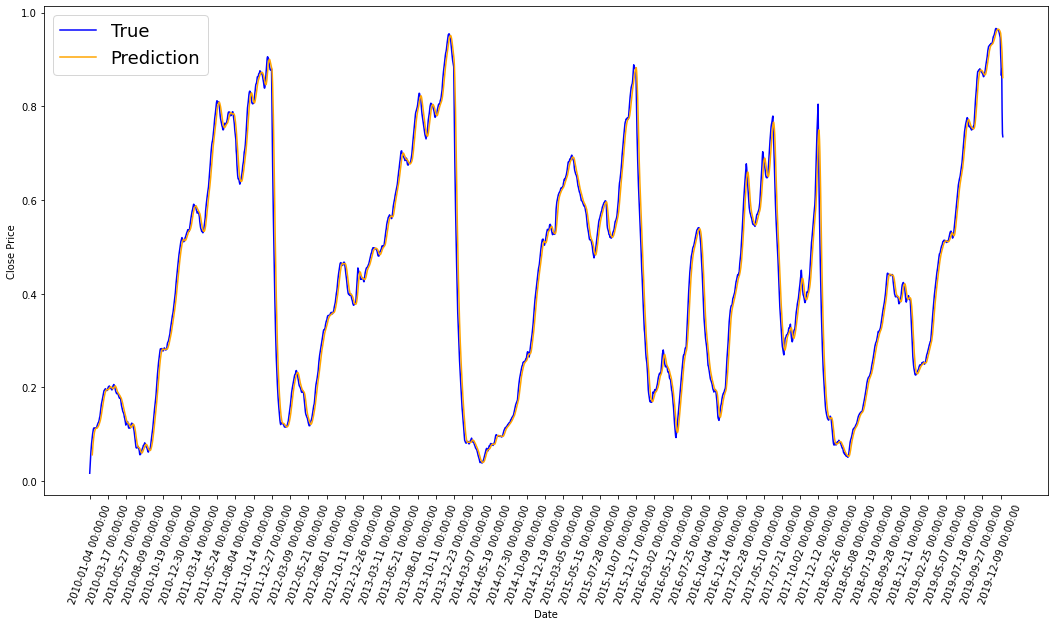

In [10]:
# Plot the train picture
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),train_data_norm,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=70)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

Get EMA

In [11]:
window_size = 7
N = train_data_norm.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []


running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data_norm[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data_norm[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging:',np.mean(mse_errors))



MSE error for EMA averaging: 0.0002916566131125514


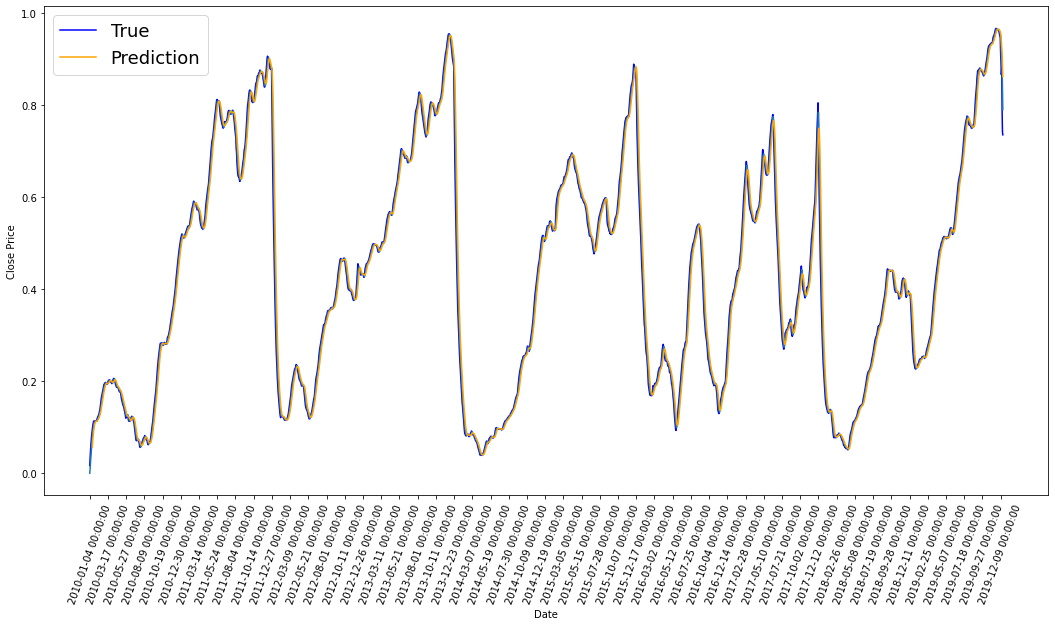

In [12]:
# plot
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),train_data_norm,color='b',label='True')
plt.plot(run_avg_predictions)
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=70)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

**LSTM MODEL**

In [13]:
# define input sequence and no. of features
raw_seq = train_data_norm
n_features = raw_seq.ndim
data_size = len(raw_seq)

print("n_features:", n_features) 
print("data_size:", data_size)

n_features: 1
data_size: 2507


In [14]:
#split the dataset into train, validation and test
train_ratio = 0.6
val_ratio = 0.8
train_size = round(train_ratio * data_size)
val_size = round(val_ratio * data_size)
test_size = data_size-val_size
train_seq = raw_seq[:train_size]
val_seq= raw_seq[train_size:val_size]
test_seq = raw_seq[val_size:]

print("train_size:", train_size)
print("dev_size:", val_size-train_size)
print("test_size:", data_size-val_size)

train_size: 1504
dev_size: 502
test_size: 501


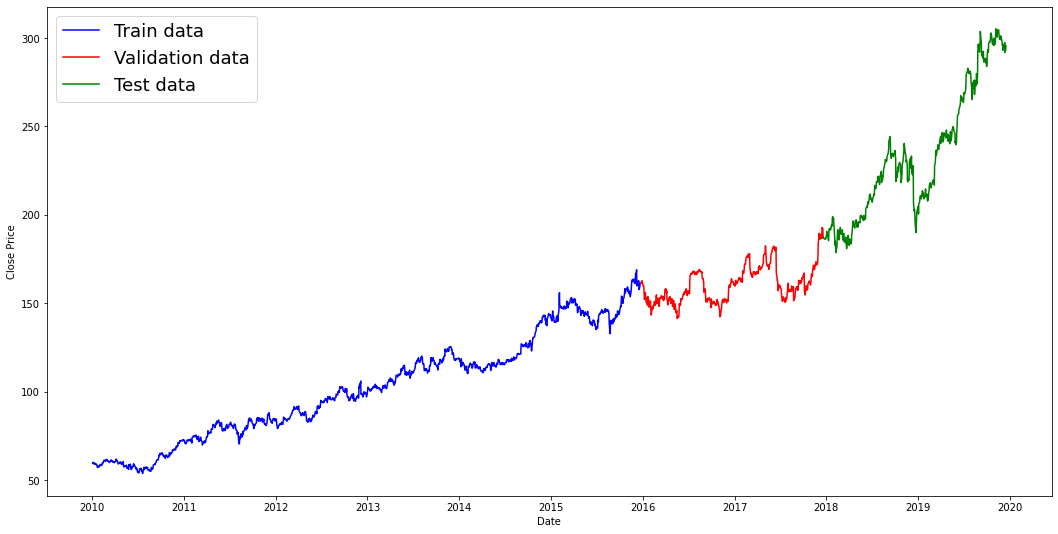

In [15]:
#plot the figure
date_list = df['Date'].tolist()
date_list1= date_list[:1504]
date_list2= date_list[1504:2006]
date_list3 = date_list[2006:]

train_seq_org = org_data[:train_size]
val_seq_org= org_data[train_size:val_size]
test_seq_org = org_data[val_size:]


plt.figure(figsize = (18,9))
plt.plot(date_list1,train_seq_org,color='b',label='Train data')
plt.plot(date_list2,val_seq_org,color='r',label='Validation data')
plt.plot(date_list3,test_seq_org,color='g',label='Test data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [16]:
# choose a number of time steps
n_steps = 7

# split into training samples,dev samples
x_train, y_train = split_sequence(train_seq, n_steps)
x_val, y_val = split_sequence(val_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (1497, 7, 1)
y_train shape: (1497,)
x_val shape: (495, 7, 1)
y_val shape: (495,)


In [17]:
x_train

array([[[0.01683599],
        [0.03146589],
        [0.04686792],
        ...,
        [0.07035779],
        [0.07998383],
        [0.08771839]],

       [[0.03146589],
        [0.04686792],
        [0.05988795],
        ...,
        [0.07998383],
        [0.08771839],
        [0.09575352]],

       [[0.04686792],
        [0.05988795],
        [0.07035779],
        ...,
        [0.08771839],
        [0.09575352],
        [0.10101126]],

       ...,

       [[0.88401861],
        [0.88367264],
        [0.88022616],
        ...,
        [0.8792875 ],
        [0.88094811],
        [0.83302318]],

       [[0.88367264],
        [0.88022616],
        [0.88022536],
        ...,
        [0.88094811],
        [0.83302318],
        [0.78371713]],

       [[0.88022616],
        [0.88022536],
        [0.8792875 ],
        ...,
        [0.83302318],
        [0.78371713],
        [0.74284284]]])

In [18]:
y_train

array([0.09575352, 0.10101126, 0.10594642, ..., 0.78371713, 0.74284284,
       0.70986786])

In [19]:
x_val 

array([[[0.68118481],
        [0.65545291],
        [0.63107192],
        ...,
        [0.59538831],
        [0.57771814],
        [0.55775449]],

       [[0.65545291],
        [0.63107192],
        [0.61223655],
        ...,
        [0.57771814],
        [0.55775449],
        [0.54059515]],

       [[0.63107192],
        [0.61223655],
        [0.59538831],
        ...,
        [0.55775449],
        [0.54059515],
        [0.52208567]],

       ...,

       [[0.74526234],
        [0.76377526],
        [0.78431095],
        ...,
        [0.73164075],
        [0.6661149 ],
        [0.60575933]],

       [[0.76377526],
        [0.78431095],
        [0.80442968],
        ...,
        [0.6661149 ],
        [0.60575933],
        [0.55633664]],

       [[0.78431095],
        [0.80442968],
        [0.73164075],
        ...,
        [0.60575933],
        [0.55633664],
        [0.51152446]]])

In [20]:
y_val

array([0.54059515, 0.52208567, 0.49790696, 0.47053186, 0.45130135,
       0.43676994, 0.41552924, 0.39860859, 0.37760003, 0.35885807,
       0.33857204, 0.32354643, 0.31688064, 0.30485283, 0.28930437,
       0.27371556, 0.26353895, 0.25754968, 0.25242865, 0.24212261,
       0.22911815, 0.21032899, 0.19488965, 0.18727143, 0.18232098,
       0.17809346, 0.17138832, 0.16949705, 0.1687479 , 0.17180269,
       0.16986999, 0.16823415, 0.16957937, 0.17141159, 0.18033217,
       0.19012163, 0.18849086, 0.18774827, 0.18809507, 0.19310988,
       0.19515794, 0.19555099, 0.19024906, 0.19123659, 0.19647591,
       0.20081838, 0.20439515, 0.20753136, 0.21348218, 0.21858932,
       0.22272998, 0.22502711, 0.22873117, 0.22852224, 0.23098594,
       0.22889418, 0.22958049, 0.23556381, 0.24579656, 0.25496459,
       0.26460383, 0.27220187, 0.27543541, 0.2799615 , 0.2742152 ,
       0.26825629, 0.25750691, 0.25087785, 0.24772918, 0.24390095,
       0.24412242, 0.24459108, 0.24580008, 0.24494083, 0.24143

Train on 1497 samples, validate on 495 samples
Epoch 1/50
1497/1497 [==============================] - 4s 2ms/sample - loss: 0.1477 - val_loss: 0.0278
Epoch 2/50
1497/1497 [==============================] - 1s 432us/sample - loss: 0.0144 - val_loss: 0.0044
Epoch 3/50
1497/1497 [==============================] - 1s 437us/sample - loss: 0.0045 - val_loss: 0.0031
Epoch 4/50
1497/1497 [==============================] - 1s 449us/sample - loss: 0.0034 - val_loss: 0.0024
Epoch 5/50
1497/1497 [==============================] - 1s 452us/sample - loss: 0.0027 - val_loss: 0.0022
Epoch 6/50
1497/1497 [==============================] - 1s 463us/sample - loss: 0.0024 - val_loss: 0.0021
Epoch 7/50
1497/1497 [==============================] - 1s 445us/sample - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50
1497/1497 [==============================] - 1s 454us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 9/50
1497/1497 [==============================] - 1s 427us/sample - loss: 0.0015 - val_loss: 0.0015
E

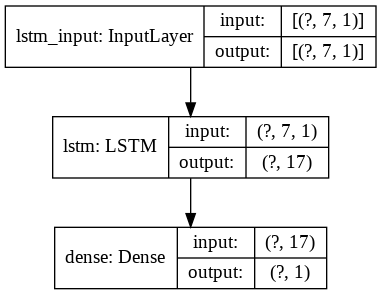

In [21]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep 
model = Sequential()
model.add(LSTM(17, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mean_squared_error")
history = model.fit(
    x=x_train, y=y_train, batch_size=None, epochs=50, verbose=1, callbacks=None,
    validation_split=0.0, validation_data=(x_val,y_val), shuffle=True, class_weight=None,
    sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_freq=1, max_queue_size=10, workers=1,
    use_multiprocessing=False)
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
model.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM 
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 17)                1292      
_________________________________________________________________
dense (Dense)                (None, 1)                 18        
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
_________________________________________________________________


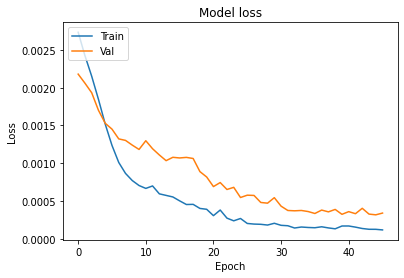

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'][4:])
plt.plot(history.history['val_loss'][4:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [24]:
# predict the next day
index = train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)
print(x_seq)
print("Predicted:", yhat[0][0])
print("Actual:", y)

[[[0.88022536]
  [0.8792875 ]
  [0.88094811]
  [0.83302318]
  [0.78371713]
  [0.74284284]
  [0.70986786]]]
Predicted: 0.65968835
Actual: 0.6811848061744652


In [25]:
# Predict the rest of the series and comparing to the test set
# Each prediction is based on the "actual" observation from the past days
# use the predicted values as new observations to further predict the rest of the series

predictedList = []
actualList = []
mse = []

for i in range(val_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

for i in range(len(predictedList)):
  print("Predicted:", round(predictedList[i], 2),
       " Actual:", round(actualList[i], 2),
       " Error:", round(actualList[i]-predictedList[i], 2))
  mse.append((actualList[i]-predictedList[i])**2)
print("The MSE of the prediction is:",np.mean(mse))

Predicted: 0.42  Actual: 0.43  Error: 0.01
Predicted: 0.4  Actual: 0.39  Error: -0.01
Predicted: 0.38  Actual: 0.36  Error: -0.02
Predicted: 0.36  Actual: 0.33  Error: -0.03
Predicted: 0.33  Actual: 0.3  Error: -0.03
Predicted: 0.31  Actual: 0.28  Error: -0.03
Predicted: 0.29  Actual: 0.26  Error: -0.03
Predicted: 0.27  Actual: 0.24  Error: -0.03
Predicted: 0.25  Actual: 0.22  Error: -0.03
Predicted: 0.24  Actual: 0.21  Error: -0.03
Predicted: 0.23  Actual: 0.2  Error: -0.03
Predicted: 0.21  Actual: 0.18  Error: -0.03
Predicted: 0.2  Actual: 0.17  Error: -0.03
Predicted: 0.19  Actual: 0.16  Error: -0.03
Predicted: 0.18  Actual: 0.15  Error: -0.02
Predicted: 0.17  Actual: 0.15  Error: -0.02
Predicted: 0.16  Actual: 0.14  Error: -0.02
Predicted: 0.15  Actual: 0.14  Error: -0.01
Predicted: 0.15  Actual: 0.14  Error: -0.01
Predicted: 0.14  Actual: 0.13  Error: -0.01
Predicted: 0.14  Actual: 0.13  Error: -0.01
Predicted: 0.14  Actual: 0.13  Error: -0.01
Predicted: 0.14  Actual: 0.13  Error:

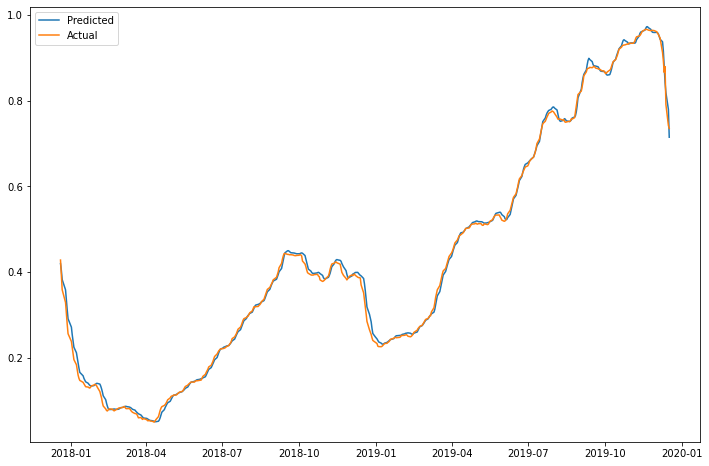

In [26]:
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(date_list3,predictedList, label="Predicted")
plt.plot(date_list3,actualList, label="Actual")
plt.legend()

In [38]:
import math
#print(test_seq_org)
#the buy and sell signal for the trading. 1 for buy ,-1 for sell
signal = 1
#Strategy Part

#Holding the stock for the whole period without price prediction
return_for_hold = math.log(test_seq_org[len(test_seq_org)-1]/test_seq_org[0]) 
print("The return of holding the whole period is:", return_for_hold )

# return of LSTM of one day
volumn1 = 0
return_list1 = []
for i in range (1, len(predictedList)):
  if predictedList[i] > predictedList[i-1]:
    signal =1
    volumn1 += 1
    return_oneday = signal * (math.log(test_seq_org[i]/test_seq_org[i-1]))
    return_list1.append(return_oneday)
  elif predictedList[i] < predictedList[i-1]:
    if volumn1 >0:
      signal = -1
      volumn1 -= 1
      return_oneday = signal * (math.log(test_seq_org[i]/test_seq_org[i-1]))
      return_list1.append(return_oneday)
    else:
      pass

print("The return of the LSTM strategy for one day is:", sum(return_list1))

# return of EMA of one day
volumn2 =0
return_by_EMA1 = []
for i in range (1, len(test_seq_org)):
  if std_avg_predictions[i] > std_avg_predictions[i-1]:
    signal =1
    volumn2 += 1
    return_ema_oneday = signal * (math.log(test_seq_org[i]/test_seq_org[i-1]))
    return_by_EMA1.append(return_ema_oneday)
  elif std_avg_predictions[i] < std_avg_predictions[i-1]:
    if volumn2 >0:
      signal = -1
      volumn2 -=1
      return_ema_oneday = signal * (math.log(test_seq_org[i]/test_seq_org[i-1]))
      return_by_EMA1.append(return_ema_oneday)
    else:
      pass
print("The return of the EMA prediction for one day is:", sum(return_by_EMA1))

The return of holding the whole period is: 0.4550058379413016
The return of the LSTM strategy for one day is: 0.17872934429993625
The return of the EMA prediction for one day is: -0.13782086113012249


In [40]:
# return of LSTM of five days
volumn3 = 0
return_list2 = []
for i in range (5, len(predictedList)):
  if predictedList[i] > predictedList[i-5] and predictedList[i] > predictedList[i-4] and predictedList[i]\
   > predictedList[i-3] and predictedList[i] > predictedList[i-2] and predictedList[i] > predictedList[i-1]:
    signal =1
    volumn3 += 1
    return_fiveday = signal * (math.log(test_seq_org[i]/test_seq_org[i-5]))
    return_list2.append(return_fiveday)
  elif  predictedList[i] < predictedList[i-5] and predictedList[i] < predictedList[i-4] and predictedList[i] \
  < predictedList[i-3] and predictedList[i] < predictedList[i-2] and predictedList[i] < predictedList[i-1]:
    if volumn3 >0:
      signal = -1
      volumn3 -= 1
      return_fiveday = signal * (math.log(test_seq_org[i]/test_seq_org[i-5]))
      return_list2.append(return_fiveday)
    else:
      pass

print("The return of the LSTM strategy for five day is:", sum(return_list2))

# return of EMA of five days
volumn4 =0
return_by_EMA2 = []
for i in range (5, len(test_seq_org)):
  if std_avg_predictions[i] > std_avg_predictions[i-5] and std_avg_predictions[i] > std_avg_predictions[i-4] \
  and std_avg_predictions[i] > std_avg_predictions[i-3] and std_avg_predictions[i] > std_avg_predictions[i-2] \
  and std_avg_predictions[i] > std_avg_predictions[i-1]:
    signal =1
    volumn4 += 1
    return_ema_fiveday = signal * (math.log(test_seq_org[i]/test_seq_org[i-5]))
    return_by_EMA2.append(return_ema_fiveday)
  elif std_avg_predictions[i] < std_avg_predictions[i-5] and std_avg_predictions[i] < std_avg_predictions[i-4] \
       and std_avg_predictions[i] < std_avg_predictions[i-3] and std_avg_predictions[i] < std_avg_predictions[i-2] \
       and std_avg_predictions[i] < std_avg_predictions[i-1]:
    if volumn4 >0:
      signal = -1
      volumn4 -=1
      return_ema_fiveday = signal * (math.log(test_seq_org[i]/test_seq_org[i-5]))
      return_by_EMA2.append(return_ema_fiveday)
    else:
      pass
print("The return of the EMA prediction for five days is:", sum(return_by_EMA2))

The return of the LSTM strategy for five day is: 4.203152568434919
The return of the EMA prediction for five days is: 0.30502851802045494
